# Multiple time series prediction for random laser spectrra based on CNN-LSTM-Attention model

In [2]:
"""
@author: shilong he
"""

import graphviz
import keras.backend
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import *
from keras.losses import mean_squared_error
from keras.models import *
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
from scipy.stats import pearsonr
np.random.seed(10)

Using TensorFlow backend.


In [2]:
import platform
print('python_version',platform.python_version())

print('tensorflow_version',tf.__version__)
for module in keras, graphviz, np, pd:
    print(module.__name__, module.__version__)

python_version 3.6.13
tensorflow_version 2.0.0
keras 2.3.1
graphviz 0.19.1
numpy 1.19.5
pandas 1.1.5


## Generate LCG PRNG

In [5]:
#  Import total spectral data
def lcg(seed, a, c, m):
    while True:
        seed = (a * seed + c) % m
        yield seed

# # 选择参数
a = 16807  # 乘数
c = 1  # 增量
m = 2**12  # 模数
seed = 12345  # 种子

# 选择参数 随机性最差
# a = 16807  # 乘数
# c = 0  # 增量
# m = 2**12  # 模数
# seed = 12345  # 种子

# 创建LCG生成器
random_number_generator = lcg(seed, a, c, m)

# 生成并打印10个0到1之间的随机数
PRNG=[]
for _ in range(5000*134):
    random_integer = next(random_number_generator)
    random_float = random_integer / m
    PRNG.append([random_float])
PRNG=np.array(PRNG).reshape(-1,134) #.reshape(-1,2)

# np.random.seed(10)
# PRNG=np.random.random(100000)  #（5000，2）

In [6]:
PRNG.shape

(5000, 134)

In [7]:
# transposed
DataY = PRNG
frame = DataY.shape[0]
numChannels= DataY.shape[1]
frame, DataY.shape

(5000, (5000, 134))

## Split

In [8]:
X = DataY  # import data
train_x, test_x = train_test_split(
    X, train_size=int(0.8 * frame), test_size=int(0.2 * frame - 1), shuffle=False
)


In [9]:
train_frame = train_x.shape[0]
test_frame = test_x.shape[0]
train_frame, test_frame

(4000, 999)

Text(0.5, 1.0, 'Pseudo Random Numbers')

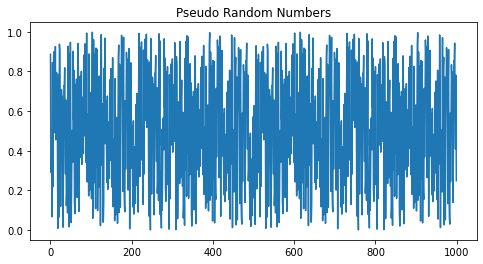

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(train_x[:1000,0])  # 第一行
plt.title("Pseudo Random Numbers")

## Reconstructing arrays with time steps

In [11]:
# batch
time_step = 32   #16 32
dataX, dataY = [], []
for i in range(train_frame - time_step):
    a = train_x[i : time_step + i]
    dataX.append(a)
    dataY.append(train_x[time_step + i])
train_X = np.array(dataX)
train_Y = np.array(dataY)  # .reshape(-1,numChannels,1)
print(train_X.shape)
print(train_Y.shape)

(3968, 32, 134)
(3968, 134)


In [12]:
testX, testY = [], []
for i in range(test_frame - time_step):
    a = test_x[i : time_step + i]
    testX.append(a)
    testY.append(test_x[time_step + i])
test_X = np.array(testX)
test_Y = np.array(testY) # .reshape(-1,numChannels,1)
print(test_X.shape)
print(test_Y.shape)

(967, 32, 134)
(967, 134)


## CNN+LSTM+Attention model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 134)      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 32, 256)      103168      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32, 256)      525312      conv1d[0][0]                     
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 32)      0           lstm[0][0]                       
____________________________________________________________________________________________

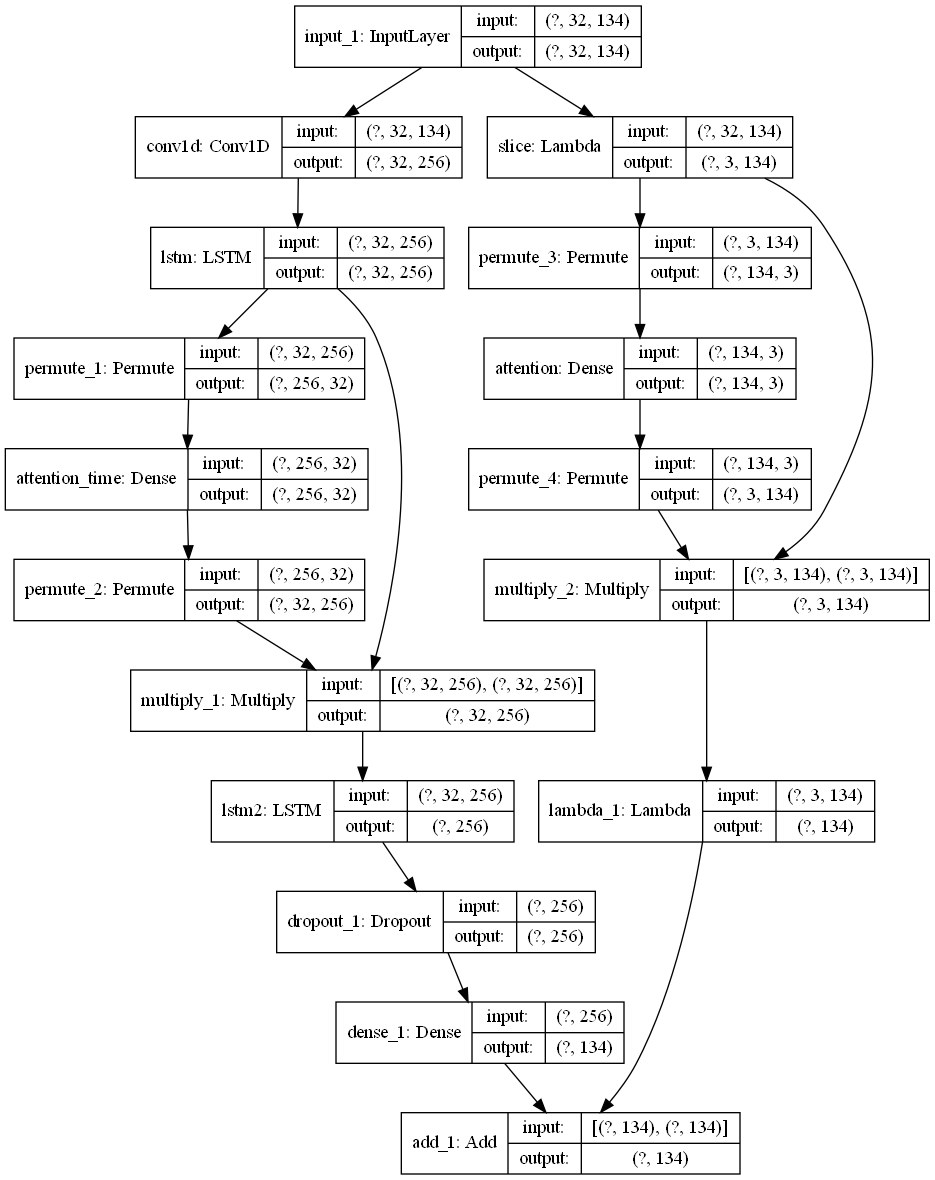

In [15]:
lstm_units = 256
dropout = 0.05
pool_size=2

inputs = Input(shape=(time_step, numChannels))

model = Conv1D(filters=256, kernel_size=3, padding="causal", activation="relu", use_bias=True, name="conv1d")(inputs)  
# model=MaxPooling1D(pool_size)(model)
# model = Conv1D(filters=256, kernel_size=3, padding="causal", activation="relu", use_bias=True)(model)  
# model=MaxPooling1D(pool_size)(model)
model = LSTM(lstm_units, return_sequences=True, name="lstm")(model)

attention_time = Permute(dims=(2, 1))(model)
# attention_time = Dense(int(time_step/pool_size**2), activation="sigmoid", name="attention_time")(attention_time)  # Attention
attention_time = Dense(time_step, activation="sigmoid", name="attention_time")(attention_time)  # Attention
attention_time = Permute(dims=(2, 1))(attention_time)
model = Multiply()([model, attention_time])  

model = LSTM(lstm_units, name="lstm2")(model)
model = Dropout(dropout)(model)  # droupout

# model = Dense(64, activation="relu")(model)
model = Dense(numChannels)(model)

slice_length=3    
lambda_slice = Lambda(lambda x:x[:,time_step-slice_length:time_step+1,:], name="slice")(inputs)

attention_time3 = Permute(dims=(2, 1))(lambda_slice)
attention_time3 = Dense(slice_length, activation="softmax", name="attention")(attention_time3)  # Attention
attention_time3 = Permute(dims=(2, 1))(attention_time3)
lambda0 = Multiply()([lambda_slice, attention_time3]) 

lambda_sum = Lambda(lambda x:keras.backend.sum(x,axis=1,keepdims=False))(lambda0) 

predictions = Add()([model,lambda_sum]) 

model = Model(inputs=inputs, outputs=predictions)

# compile
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

model.summary()  # Demonstrate model structure

plot_model(model, show_shapes=True, show_layer_names=True)  # Display Structure Forms,to_file='model.png'

In [16]:
# Train
history = model.fit(
    train_X,
    train_Y,
    epochs=60,
    batch_size=64, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
)

Train on 3968 samples, validate on 967 samples
Epoch 1/60
 - 22s - loss: 0.1117 - accuracy: 0.0000e+00 - val_loss: 0.1111 - val_accuracy: 0.0000e+00
Epoch 2/60
 - 21s - loss: 0.1111 - accuracy: 0.0000e+00 - val_loss: 0.1110 - val_accuracy: 0.0000e+00
Epoch 3/60
 - 21s - loss: 0.1110 - accuracy: 0.0000e+00 - val_loss: 0.1109 - val_accuracy: 0.0000e+00
Epoch 4/60
 - 21s - loss: 0.1109 - accuracy: 0.0000e+00 - val_loss: 0.1106 - val_accuracy: 0.0000e+00
Epoch 5/60
 - 22s - loss: 0.1104 - accuracy: 0.0000e+00 - val_loss: 0.1098 - val_accuracy: 0.0000e+00
Epoch 6/60
 - 25s - loss: 0.1096 - accuracy: 0.0000e+00 - val_loss: 0.1087 - val_accuracy: 0.0000e+00
Epoch 7/60
 - 25s - loss: 0.1078 - accuracy: 7.5605e-04 - val_loss: 0.1056 - val_accuracy: 0.0021
Epoch 8/60
 - 23s - loss: 0.1047 - accuracy: 0.0040 - val_loss: 0.1023 - val_accuracy: 0.0021
Epoch 9/60
 - 22s - loss: 0.1013 - accuracy: 0.0076 - val_loss: 0.0986 - val_accuracy: 0.0041
Epoch 10/60
 - 23s - loss: 0.0977 - accuracy: 0.0088 - 

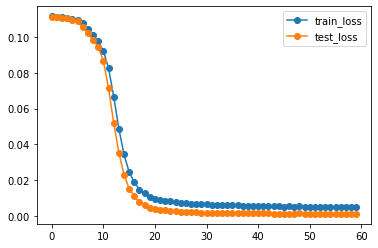

In [17]:
# Loss
plt.plot(history.history["loss"],'o-', label="train_loss")
plt.plot(history.history["val_loss"],'o-', label="test_loss")
# plt.ylim(0, 0.2)
plt.legend()
plt.show()

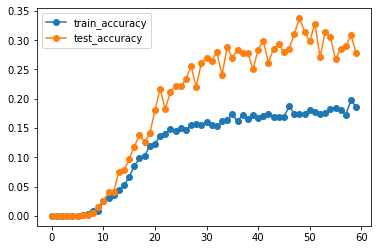

In [18]:
plt.plot(history.history["accuracy"],'o-', label="train_accuracy")
plt.plot(history.history["val_accuracy"],'o-', label="test_accuracy")
# plt.ylim(0, 0.5)
plt.legend()
plt.show()

## Forecasting

In [20]:
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((967, 134), (967, 134))

In [21]:
# np.save('test_Y_PRNG_CLA',test_Y)
# np.save('test_Y_predict_PRNG_CLA',test_Y_predict)

In [39]:
test_Y= np.load("test_Y_PRNG_CLA.npy")
test_Y_predict = np.load('test_Y_predict_PRNG_CLA.npy')
# from scipy import io
# mat=np.load('test_Y_article.npy')
# io.savemat('test_Y_134_32.mat', {'test_Y_134_32': mat})
# mat1=np.load('test_Y_article_predict.npy')
# io.savemat('test_Y_134_32_predict.mat', {'test_Y_134_32_predict': mat1})

Text(0, 0.5, 'Random number (a.u.)')

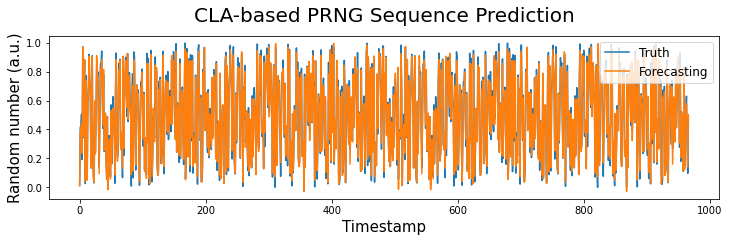

In [23]:
fig = plt.figure(figsize=(12,13))  # 宽，高
draw = pd.concat([pd.DataFrame(test_Y[:,0]), pd.DataFrame(test_Y_predict[:,0])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 3))
draw.iloc[:, 1].plot(figsize=(12, 3))
plt.legend(("Truth", "Forecasting"), fontsize="12")
plt.title("CLA-based PRNG Sequence Prediction", fontsize="20", y=1.05) 
plt.xlabel("Timestamp", fontsize="15")
plt.ylabel("Random number (a.u.)", fontsize="15")
# plt.savefig("CLA_5000_PRNG.png",dpi=300, bbox_inches='tight')

# plt.subplot(212)
# draw2 = pd.concat([pd.DataFrame(test_Y[1, :]), pd.DataFrame(test_Y_predict[1, :])], axis=1)
# draw2.iloc[:, 0].plot(figsize=(12, 6))
# draw2.iloc[:, 1].plot(figsize=(12, 6))
# plt.legend(("real", "predict"), fontsize="15")
# plt.title("Test Data 2", fontsize="30")  # 添加标题

In [24]:
# draw2 = pd.concat([pd.DataFrame(test_Y[:,62]), pd.DataFrame(test_Y_predict[:,62])], axis=1)
# draw2.iloc[:, 0].plot(figsize=(12, 4))
# draw2.iloc[:, 1].plot(figsize=(12, 4))
# plt.ylim(0, 10)
# plt.legend(("real", "predict"), fontsize="15")
# plt.title("572.8 nm", fontsize="20")  
# plt.xlabel("Timestamp", fontsize="20")

Text(0, 0.5, 'Random number (a.u.)')

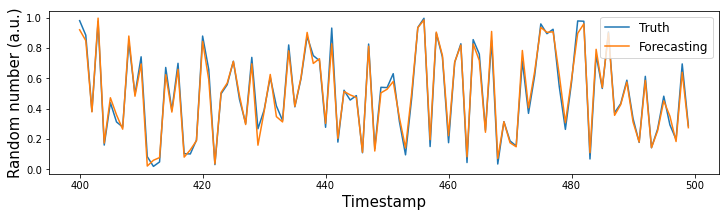

In [25]:
draw2_crop = pd.concat([pd.DataFrame(test_Y[400:500,0]), pd.DataFrame(test_Y_predict[400:500,0])], axis=1)
draw2_crop.iloc[:, 0].plot(figsize=(12, 3))
draw2_crop.iloc[:, 1].plot(figsize=(12, 3))
plt.xticks([0,20,40,60,80,100],[400,420,440,460,480,500])

plt.legend(("Truth", "Forecasting"), fontsize="12")
plt.xlabel("Timestamp", fontsize="15")
plt.ylabel("Random number (a.u.)", fontsize="15")
# plt.savefig("CLA_5000_PRNG_local.png",dpi=300, bbox_inches='tight')

In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print("Test set:")
print("MAE:{}".format(mean_absolute_error(test_Y_predict, test_Y)))
print("MSE:{}".format(mean_squared_error(test_Y_predict, test_Y)))
print("MAPE:{}".format(mape(test_Y_predict, test_Y)))

Test set:
MAE:0.02618067315010939
MSE:0.001098356436831448
MAPE:22.638586549722383


In [27]:
correlation, _ = pearsonr(test_Y[400:1500,0], test_Y_predict[400:1500,0])
correlation

0.9934654847501849

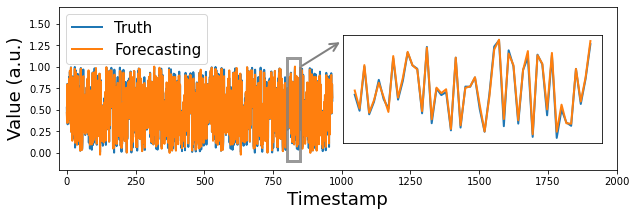

In [40]:
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib.widgets import RectangleSelector

# 创建一个大的图形和坐标轴
fig, ax1 = plt.subplots(figsize=(10,3))

m=60
# 在大坐标轴上绘制数据
ax1.plot(test_Y[:,m],linewidth=2)
ax1.plot(test_Y_predict[:,m],linewidth=2)
plt.legend(("Truth", "Forecasting"), fontsize="15", loc="upper left")
plt.xlabel("Timestamp", fontsize="18")
plt.ylabel("Value (a.u.)", fontsize="18")
plt.ylim(-0.2,1.7)
plt.xlim(-30,2000)

# 创建一个小的坐标轴，位置和大小由坐标轴的坐标（左、下、宽、高）决定
# 这些坐标值的范围在0到1之间，表示相对于大坐标轴的位置和大小
ax2 = fig.add_axes([0.52, 0.25, 0.36, 0.5])  # [left, bottom, width, height]

# 在小坐标轴上绘制数据
ax2.plot(test_Y[800:850,m],linewidth=2)
ax2.plot(test_Y_predict[800:850,m],linewidth=2)
plt.xticks([])
plt.yticks([])
# ax2.set_title('小图')

# 添加矩形框
# 矩形框的位置和大小由坐标轴的坐标（左、下、宽、高）决定
rect = Rectangle((800, -0.1), 50, 1.2, linewidth=3, edgecolor='gray', facecolor='none', alpha=0.8, linestyle='-', zorder=10)
ax1.add_patch(rect)

# 添加箭头
# 箭头的起点和终点坐标需要根据实际位置进行调整
arrow = FancyArrowPatch((850, 1), (1000, 1.3), arrowstyle='->', mutation_scale=20, color='gray', linewidth=2)
ax1.add_patch(arrow)

# plt.savefig("CLA_5000_all.pdf",dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

In [3]:
test_Y=np.load("test_Y_RL_CLA.npy")
test_Y_predict=np.load("test_Y_predict_RL_CLA.npy")
test_Y.shape,test_Y_predict.shape

((967, 134), (967, 134))

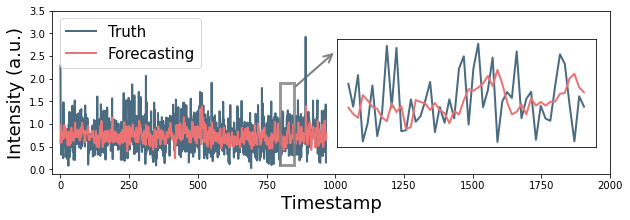

In [4]:

from matplotlib.patches import Rectangle, FancyArrowPatch

# 创建一个大的图形和坐标轴
fig, ax1 = plt.subplots(figsize=(10,3))
m=50
# 在大坐标轴上绘制数据
ax1.plot(test_Y[:,m], color=[0.29,0.42,0.50],linewidth=2)
ax1.plot(test_Y_predict[:,m], color=[0.92,0.45,0.45],linewidth=2)
plt.legend(("Truth", "Forecasting"), fontsize="15", loc="upper left")
plt.xlabel("Timestamp", fontsize="18")
plt.ylabel("Intensity (a.u.)", fontsize="18")
plt.ylim(-0.1,3.5)
plt.xlim(-30,2000)

# 创建一个小的坐标轴，位置和大小由坐标轴的坐标（左、下、宽、高）决定
# 这些坐标值的范围在0到1之间，表示相对于大坐标轴的位置和大小
ax2 = fig.add_axes([0.52, 0.25, 0.36, 0.5])  # [left, bottom, width, height]

# 在小坐标轴上绘制数据
ax2.plot(test_Y[800:850,m], color=[0.29,0.42,0.50],linewidth=2)
ax2.plot(test_Y_predict[800:850,m], color=[0.92,0.45,0.45],linewidth=2)
plt.xticks([])
plt.yticks([])
# ax2.set_title('小图')

# 添加矩形框
# 矩形框的位置和大小由坐标轴的坐标（左、下、宽、高）决定
rect = Rectangle((800, 0.1), 50, 1.8, linewidth=3, edgecolor='gray', facecolor='none', alpha=0.8, linestyle='-', zorder=10)
ax1.add_patch(rect)

# 添加箭头
# 箭头的起点和终点坐标需要根据实际位置进行调整
arrow = FancyArrowPatch((850, 1.8), (1000, 2.6), arrowstyle='->', mutation_scale=20, color='gray', linewidth=2)
ax1.add_patch(arrow)

# plt.savefig("CLA_RL_all.png",dpi=300, bbox_inches='tight')

# 显示图形
plt.show()

In [32]:
correlation, _ = pearsonr(test_Y[:,m], test_Y_predict[:,m])
correlation

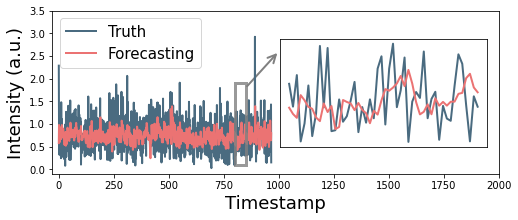

In [6]:
from matplotlib.patches import Rectangle, FancyArrowPatch

# 创建一个大的图形和坐标轴
fig, ax1 = plt.subplots(figsize=(8,3))
m=50
# 在大坐标轴上绘制数据
ax1.plot(test_Y[:,m], color=[0.29,0.42,0.50],linewidth=2)
ax1.plot(test_Y_predict[:,m], color=[0.92,0.45,0.45],linewidth=2)
plt.legend(("Truth", "Forecasting"), fontsize="15", loc="upper left")
plt.xlabel("Timestamp", fontsize="18")
plt.ylabel("Intensity (a.u.)", fontsize="18")
plt.ylim(-0.1,3.5)
plt.xlim(-30,2000)

# 创建一个小的坐标轴，位置和大小由坐标轴的坐标（左、下、宽、高）决定
# 这些坐标值的范围在0到1之间，表示相对于大坐标轴的位置和大小
ax2 = fig.add_axes([0.52, 0.25, 0.36, 0.5])  # [left, bottom, width, height]

# 在小坐标轴上绘制数据
ax2.plot(test_Y[800:850,m], color=[0.29,0.42,0.50],linewidth=2)
ax2.plot(test_Y_predict[800:850,m], color=[0.92,0.45,0.45],linewidth=2)
plt.xticks([])
plt.yticks([])
# ax2.set_title('小图')

# 添加矩形框
# 矩形框的位置和大小由坐标轴的坐标（左、下、宽、高）决定
rect = Rectangle((800, 0.1), 50, 1.8, linewidth=3, edgecolor='gray', facecolor='none', alpha=0.8, linestyle='-', zorder=10)
ax1.add_patch(rect)

# 添加箭头
# 箭头的起点和终点坐标需要根据实际位置进行调整
arrow = FancyArrowPatch((850, 1.8), (1000, 2.6), arrowstyle='->', mutation_scale=20, color='gray', linewidth=2)
ax1.add_patch(arrow)

# plt.savefig("CLA_RL_all.png",dpi=300, bbox_inches='tight')

# 显示图形
plt.show()